In [166]:
import datetime
print('Last updated:', datetime.datetime.now(), '(PT)')

Last updated: 2020-07-16 00:38:28.773753 (PT)


In [167]:
import pystan
import numpy as np
import json
import matplotlib.pyplot as plt
import sys
sys.path.append('../../src/dp-gmm/util')
from pystan_vb_extract import pystan_vb_extract
import copy

In [168]:
import pystan
from scipy.stats import multivariate_normal

In [236]:
# See: https://maggielieu.com/2017/03/21/multivariate-gaussian-mixture-model-done-properly/
# See: https://mc-stan.org/docs/2_19/stan-users-guide/gaussian-process-regression.html
warped_mixture = """
data {
    int D;               // number of dimensions
    int K;               // number of gaussians
    int N;               // number of data
    matrix[N,D] y;       // data
    vector[K] eta;       // dirichlet parameter
    real<lower=0> eps;   // nugget for exponential kernel for stability.
}
parameters {
    simplex[K] w;                 // mixing proportions
    ordered[D] mu[K];             // mixture component means
    cholesky_factor_corr[D] L[K]; // cholesky factor of covariance
    real<lower=0> v;              // model variance
    real<lower=0> rho;            // range parameter in GP covariance fn
    matrix[N,D] x;                // latent parameters
    
    // vector[D] x[N]; // latent params
}
transformed parameters {
    real<upper=0> soft_c[N, K]; // log unnormalized clusters
    for (n in 1:N) {
        for (k in 1:K) {
            soft_c[n, k] = log(w[k]) + multi_normal_cholesky_lpdf(x[n, :] | mu[k], L[k]);
        }
    }
}
model {
    // real ps[K];
    matrix[N, N] L_KK;
    matrix[N, N] KK[D];

    v ~ lognormal(0, 1);  // model variance
    
    w ~ dirichlet(eta);
    rho ~ lognormal(0, 10);
   
    for(k in 1:K){
       mu[k] ~ normal(0, sqrt(v));
       
       // https://mc-stan.org/docs/2_18/stan-users-guide/multivariate-hierarchical-priors-section.html
       L[k] ~ lkj_corr_cholesky(2);
    }
    
    for (n in 1:N){
       target += log_sum_exp(soft_c[n, :]);
    }
    
    for (d in 1:D) {
        KK[d] = cov_exp_quad(to_array_1d(x[:, d]), 1.0, rho); 
        
        // diagonal elements
        for (n in 1:N) {
            KK[d][n, n] = KK[d][n, n] + eps + v;
        }
        
        L_KK = cholesky_decompose(KK[d]);

        // Marginalized GP likelihood.
        y[:, d] ~ multi_normal_cholesky(rep_vector(0.0, N), L_KK);
    }
}
"""

In [237]:
%%time
sm = pystan.StanModel(model_code=warped_mixture)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0df8257f3dd7670d06eb3dd7c1a56a16 NOW.


CPU times: user 925 ms, sys: 46.9 ms, total: 972 ms
Wall time: 57.4 s


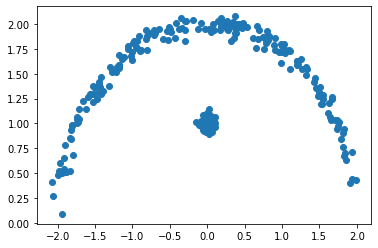

In [238]:
def gen_rainbow_data(N1=200, N2=100, r=2, s=0.1, sx=0.01, sy=0.01):
    x1 = np.random.rand(N1) * 2 * r - r
    y1 = np.sqrt(r*r - x1*x1)
    x2 = np.random.randn(N2) * sx
    y2 = np.random.randn(N2) * sy + 1
    x = np.concatenate([x1, x2])
    y = np.concatenate([y1, y2])
    z = np.stack([x, y], axis=1)
    return z + np.random.randn(N1 + N2, 2) * s

# Generate data
np.random.seed(1)
y = gen_rainbow_data(s=0.05)
plt.scatter(y[:, 0], y[:, 1]);

In [239]:
# Data dictionary
K = 10
N, D = y.shape
data = dict(y=y, D=D, N=N, K=K, eta=np.full(K, 1/K), eps=1e-3)
init = dict(x=np.random.randn(N, D))

In [240]:
%%time
# Fit via ADVI
vb_fit = sm.vb(data=data, iter=4000, seed=2, init=init)

CPU times: user 1min 6s, sys: 228 ms, total: 1min 6s
Wall time: 1min 6s


In [241]:
samples = pystan_vb_extract(vb_fit)

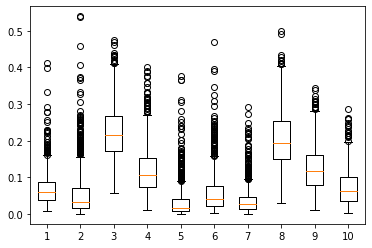

In [242]:
plt.boxplot(samples['w']);

In [243]:
x = samples['x']
mu = samples['mu']
w_mean = samples['w'].mean(0)

In [244]:
x_mean = x.mean(0)

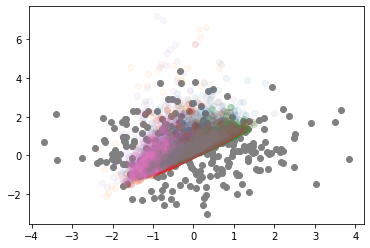

In [266]:
# plt.scatter(x_mean[:, 0], x_mean[:, 1], c='grey');

# FIXME: Something looks off here...
plt.scatter(x[3, :, 0], x[3, :, 1], c='grey');
for k in range(data['K']):
    if w_mean[k] > 0.05:
        plt.scatter(mu[:, k, 0], mu[:, k, 1], alpha=w_mean[k]);

In [246]:
# z = samples['z'].mean(0)
# plt.scatter(z[:, 0], z[:, 1]);

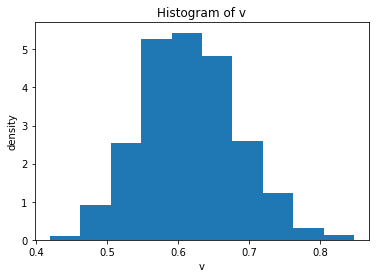

In [248]:
plt.hist(samples['v'], density=True)
plt.xlabel("v")
plt.ylabel("density")
plt.title("Histogram of v");

In [249]:
def compute_probs(soft_c):
    unnormalized_probs = np.exp(soft_c - soft_c.max(-1, keepdims=True))
    probs = unnormalized_probs / unnormalized_probs.sum(-1, keepdims=True)
    return probs

In [250]:
probs = compute_probs(samples['soft_c'])
probs.mean(0).argmax(1)

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 7, 2, 2, 8, 2, 8, 2, 2, 2, 2, 2, 7,
       2, 2, 2, 8, 2, 2, 2, 8, 2, 2, 2, 2, 2, 2, 8, 2, 2, 2, 2, 8, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 7, 2, 2, 2, 2, 2, 2, 2, 2, 8, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 8, 2, 8, 2, 2, 2, 2, 8, 2, 2,
       8, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 8, 2, 2, 2, 2, 8, 2, 2,
       2, 2, 2, 2, 2, 8, 2, 8, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 7, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 8, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       7, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 8, 2, 2, 2, 8, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 8, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 8, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 8, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 7, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 8,
       2, 2, 2, 2, 2, 7, 2, 8, 2, 2, 2, 2, 2, 7])

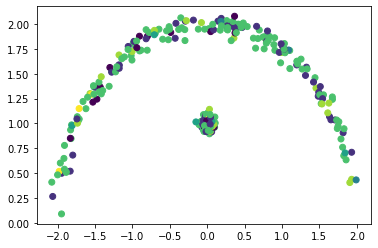

In [251]:
# labels = probs.mean(0).argmax(-1)
labels = probs[0, :, :].argmax(-1)
plt.scatter(y[:, 0], y[:, 1], c=labels);